In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Affine

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

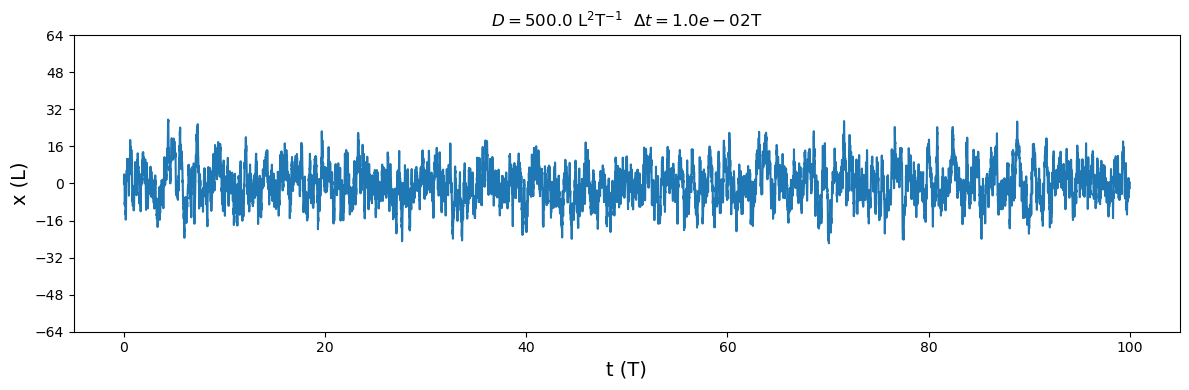

In [18]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: Set the force constant($\sigma$ of Gaussian) of Photon Operator

In [31]:
## Photon Operator
sigma_photon = 2 # unit: L
k_photon = get_k_by_sigma(sigma_photon);

### Part 5: Set Flat potential as $p_0$

In [32]:
V0 = symmetry_wall_potential.(-64., 64., 2.5, 10.0, xref)
rho_0 = get_rhoeq(V0, w0)
p0 = rho_0 .* rho_0;

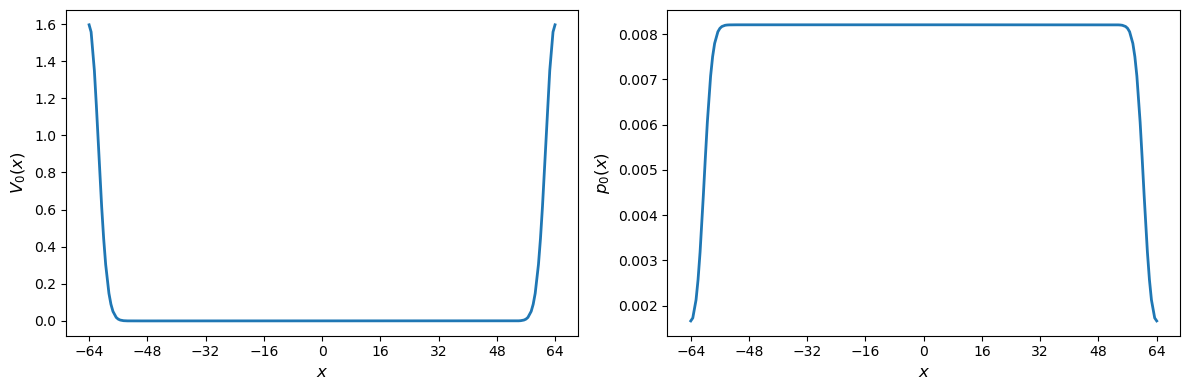

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, V0, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V_0(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, p0, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{0}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
plt.show()

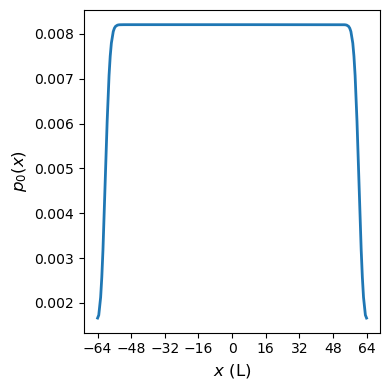

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

ax.plot(xref, p0, linewidth=2)
ax.set_xlabel("\$x\$ (L)", fontsize=12)
ax.set_ylabel("\$p_{0}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/p0.svg")
plt.show()

### Part 5-1: Set KDE potential as $p_0$

In [8]:
σ_kde = 4.
k_kde = get_k_by_sigma(σ_kde)
p0 = gaussian_kde(xref, y_record, σ_kde, w0);

### Part 6: Set D

In [9]:
D_init = 500.
D_guess = D_init * ones(Nv);

### Part 6: EM- Update $p_{\rm eq}$ fix $D=D_{\rm opt}$

In [33]:
#p_prev = p_eq;
p_prev = p0;

In [34]:
exp_ab_mat, Qx, p_em, log_likelihood = forward_backward_v3(Nh, Np, xratio, xavg, p_prev, D_guess, Nv, tau, y_record, save_freq, k_photon);

In [14]:
first = Qx * exp_ab_mat
second = Qx .* Qx;

In [21]:
p_em_translate = p_em .- minimum(p_em)
p_em_normalize = p_em_translate ./ sum(w0.*p_em_translate)
p_em_normalize = max.(p_em_normalize, 1e-10)
sum(w0 .* p_em_normalize)

1.000000000166666

In [25]:
p_prev = zeros(N,1)

p_prev[:,1] = p_em_normalize
p_em, log_likelihood = forward_backward_v3(Nh, Np, xratio, xavg, p_prev, D_guess, Nv, tau, y_record, save_freq, k_photon);

In [24]:
sum(w0 .* p_em)

0.999999999999996

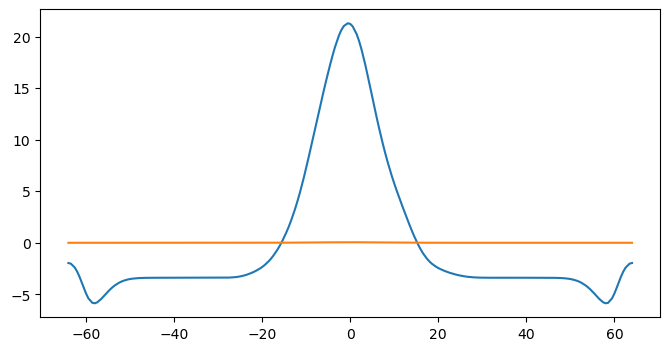

In [35]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(xref, p_em)
ax.plot(xref, p_eq)

plt.show()

In [15]:
D_init = 500. # 500
max_n_iteration = 1
f_out_pcontain = "/home/yizaochen/codes/julia/md_pisl/EM_data/peq_harmonic_well_0_second.jld"
f_out_l_record = "/home/yizaochen/codes/julia/md_pisl/EM_data/l_harmonic_well_0_second.jld";

In [16]:
p_container_1, log_likelihood_records_1 = complete_em_only_update_peq_no_converge_test_v1(max_n_iteration, N, Nh, Np, xratio, xavg, Nv, tau, y_record, 
    save_freq, xref, e_norm, w0, f_out_pcontain, f_out_l_record, k_photon, p0, D_init);

Iteration-ID: 1
Iteration-ID: 2


LoadError: [91mDomainError with -0.003948274625382254:[39m
[91mlog will only return a complex result if called with a complex argument. Try log(Complex(x)).[39m

In [ ]:
p0 = zeros(N,1)
p0[:,1] = p_container_0[1, :];

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

lastem_id = 3

ax = axes[1]
xarray = 0:lastem_id
ax.plot(xarray, log_likelihood_records_1[1:lastem_id+1], "-o", linewidth=1, markersize=2)
ax.set_xlabel("Iteration ID")
ax.set_ylabel("Log likelihood")
ax.set_xlim(-0.5, lastem_id+1)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_title(@sprintf "Converge at Iteration %d" lastem_id)

ax = axes[2]
ax.plot(xref, p_container_1[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{\\rm EM}\$")
ax.plot(xref, p_container_1[1,:], label="\$ p_0(x) \$", alpha=0.4, color="green")
ax.plot(xref_ps_affine, p_eq_ps, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
ax.set_xlabel("x (L)")
ax.set_ylabel("\$ p(x) \$")
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "Fix D=%.3f" D_init)
ax.legend()

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/0/second_peq_em.svg")
plt.show()

LoadError: [91mUndefVarError: log_likelihood_records_1 not defined[39m

### Part 9: Convert $p_{\rm eq}$ and $D$ back to physical space

In [34]:
# Define Physical Domain
xratio_ps = 50. # unit: angstrom
xavg_ps = 50.   # unit: angstrom

N, xref_ps, w0_ps, Ldx_ps, w_ps = get_fem_xref_weights_basis(Nh, Np, xratio_ps, xavg_ps);

In [35]:
xref_affine_back = Affine.length_transform_inverse.(xref)
p_eq_affine_back = p_container_1[lastem_id+1, :]
p_eq_affine_back = p_eq_affine_back / sum(w0_ps .* p_eq_affine_back)
D_affine_back = Affine.D_transform_inverse(D_init);

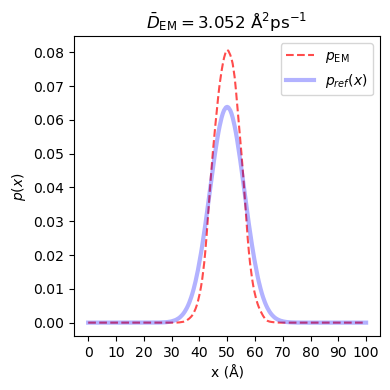

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

ax.plot(xref_ps, p_eq_affine_back, "--", color="red", alpha=0.7, label="\$p_{\\rm EM}\$")
ax.plot(xref_ps, rho_eq_ps .* rho_eq_ps, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
ax.set_xlabel("x (Å)")
ax.set_ylabel("\$ p(x) \$")
ax.set_xticks(0:10:100)
ax.set_title(@sprintf "\$\\bar{D}_{\\rm EM}=%.3f\$ Å\$^{2}\$ps\$^{-1}\$" D_affine_back)
ax.legend()

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/0/result_convert_back.svg")
plt.show()